In [1]:
# CIFAR-10 3개 클래스 분류 (개, 고양이, 말) - PyTorch

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 중인 디바이스: {device}")

# 클래스 이름 정의
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# 사용할 클래스 선택 (개, 고양이, 말)
selected_classes = ['cat', 'dog', 'horse']
selected_idx = [class_names.index(c) for c in selected_classes]
print(f"선택된 클래스: {selected_classes} (인덱스: {selected_idx})")

# 데이터 변환 정의
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 데이터셋 로드
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

# 선택된 클래스만 필터링하는 함수
def filter_classes(dataset, selected_idx):
    indices = []
    for i, (_, label) in enumerate(dataset):
        if label in selected_idx:
            indices.append(i)
    return torch.utils.data.Subset(dataset, indices)

# 데이터 필터링
train_dataset = filter_classes(train_dataset, selected_idx)
test_dataset = filter_classes(test_dataset, selected_idx)

print(f"필터링 후 데이터 크기:")
print(f"  - 학습 데이터: {len(train_dataset)}")
print(f"  - 테스트 데이터: {len(test_dataset)}")

# DataLoader
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 라벨을 0~2로 다시 매핑하는 함수
def remap_labels(labels, selected_idx):
    label_map = {v: i for i, v in enumerate(selected_idx)}
    return torch.tensor([label_map[int(label)] for label in labels])

# 데이터 샘플 확인
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(f"이미지 배치 크기: {images.shape}")
print(f"라벨 배치 크기: {labels.shape}")

# 라벨 재매핑
labels = remap_labels(labels, selected_idx)
print(f"재매핑된 라벨: {labels[:10]}")

사용 중인 디바이스: cuda
선택된 클래스: ['cat', 'dog', 'horse'] (인덱스: [3, 5, 7])


100.0%


필터링 후 데이터 크기:
  - 학습 데이터: 15000
  - 테스트 데이터: 3000
이미지 배치 크기: torch.Size([32, 3, 32, 32])
라벨 배치 크기: torch.Size([32])
재매핑된 라벨: tensor([2, 2, 0, 0, 1, 0, 0, 0, 1, 1])


In [2]:
# CNN 모델 정의
class CIFAR10_CNN(nn.Module):
    def __init__(self, num_classes=3):
        super(CIFAR10_CNN, self).__init__()
        
        # 첫 번째 컨볼루션 블록
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        
        # 두 번째 컨볼루션 블록
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # 세 번째 컨볼루션 블록
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # 네 번째 컨볼루션 블록
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        # 드롭아웃
        self.dropout = nn.Dropout(0.5)
        
        # 완전연결층
        self.fc1 = nn.Linear(128 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
    def forward(self, x):
        # 첫 번째 블록
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 두 번째 블록
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 세 번째 블록
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 네 번째 블록
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # 평탄화
        x = x.view(x.size(0), -1)
        
        # 완전연결층
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

# 모델 생성
model = CIFAR10_CNN(num_classes=3).to(device)
print(f"모델 구조:")
print(model)

# 손실함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print(f"\n모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")


모델 구조:
CIFAR10_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
)

모델 파라미터 수: 505,731


In [3]:
# 학습 함수
def train_model(model, train_loader, test_loader, num_epochs=20):
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(num_epochs):
        # 학습 모드
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # 라벨 재매핑
            labels = remap_labels(labels, selected_idx).to(device)
            
            # 옵티마이저 초기화
            optimizer.zero_grad()
            
            # 순전파
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # 역전파
            loss.backward()
            optimizer.step()
            
            # 통계
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # 에폭별 평균 손실과 정확도
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # 테스트 평가
        test_loss, test_acc = evaluate_model(model, test_loader)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
        
        # 학습률 스케줄링
        scheduler.step()
    
    return train_losses, train_accuracies, test_losses, test_accuracies

# 평가 함수
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # 라벨 재매핑
            labels = remap_labels(labels, selected_idx).to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader)
    test_acc = 100 * correct / total
    
    return test_loss, test_acc

# 모델 학습
print("학습 시작...")
train_losses, train_accs, test_losses, test_accs = train_model(model, train_loader, test_loader, num_epochs=20)


학습 시작...
Epoch [1/20], Step [0/469], Loss: 1.1572
Epoch [1/20], Step [100/469], Loss: 0.9722
Epoch [1/20], Step [200/469], Loss: 0.6851
Epoch [1/20], Step [300/469], Loss: 0.7428
Epoch [1/20], Step [400/469], Loss: 0.8831
Epoch [1/20] - Train Loss: 0.8750, Train Acc: 57.74%, Test Loss: 0.7493, Test Acc: 63.70%
Epoch [2/20], Step [0/469], Loss: 0.9888
Epoch [2/20], Step [100/469], Loss: 0.6687
Epoch [2/20], Step [200/469], Loss: 0.7508
Epoch [2/20], Step [300/469], Loss: 0.4722
Epoch [2/20], Step [400/469], Loss: 0.6504
Epoch [2/20] - Train Loss: 0.7252, Train Acc: 67.03%, Test Loss: 0.7672, Test Acc: 66.93%
Epoch [3/20], Step [0/469], Loss: 0.4276
Epoch [3/20], Step [100/469], Loss: 0.5901
Epoch [3/20], Step [200/469], Loss: 0.6158
Epoch [3/20], Step [300/469], Loss: 0.7251
Epoch [3/20], Step [400/469], Loss: 0.3665
Epoch [3/20] - Train Loss: 0.6517, Train Acc: 71.65%, Test Loss: 0.6075, Test Acc: 72.53%
Epoch [4/20], Step [0/469], Loss: 0.6473
Epoch [4/20], Step [100/469], Loss: 0.321

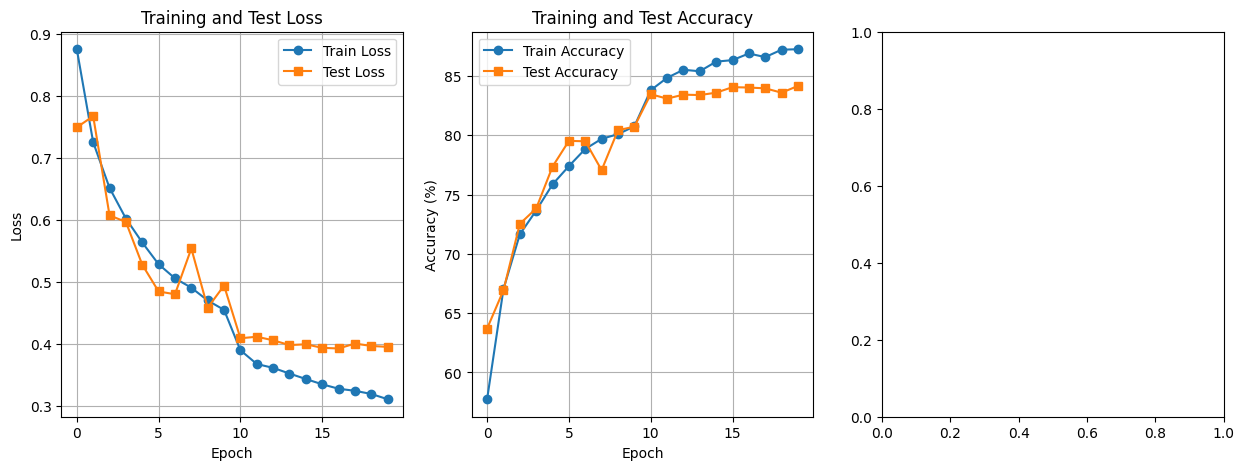

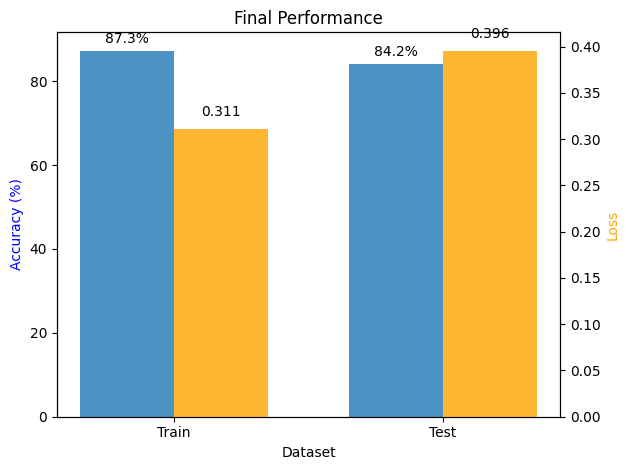


최종 성능:
학습 정확도: 87.27%
테스트 정확도: 84.17%
학습 손실: 0.3115
테스트 손실: 0.3958


In [4]:
# 학습 결과 시각화
plt.figure(figsize=(15, 5))

# 손실 그래프
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='s')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 정확도 그래프
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy', marker='o')
plt.plot(test_accs, label='Test Accuracy', marker='s')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# 최종 성능
plt.subplot(1, 3, 3)
final_train_acc = train_accs[-1]
final_test_acc = test_accs[-1]
final_train_loss = train_losses[-1]
final_test_loss = test_losses[-1]

categories = ['Train', 'Test']
accuracies = [final_train_acc, final_test_acc]
losses = [final_train_loss, final_test_loss]

x = np.arange(len(categories))
width = 0.35

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy (%)', alpha=0.8)
bars2 = ax2.bar(x + width/2, losses, width, label='Loss', alpha=0.8, color='orange')

ax1.set_xlabel('Dataset')
ax1.set_ylabel('Accuracy (%)', color='blue')
ax2.set_ylabel('Loss', color='orange')
ax1.set_title('Final Performance')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)

# 값 표시
for i, (acc, loss) in enumerate(zip(accuracies, losses)):
    ax1.text(i - width/2, acc + 1, f'{acc:.1f}%', ha='center', va='bottom')
    ax2.text(i + width/2, loss + 0.01, f'{loss:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\n최종 성능:")
print(f"학습 정확도: {final_train_acc:.2f}%")
print(f"테스트 정확도: {final_test_acc:.2f}%")
print(f"학습 손실: {final_train_loss:.4f}")
print(f"테스트 손실: {final_test_loss:.4f}")


예측 결과 시각화:


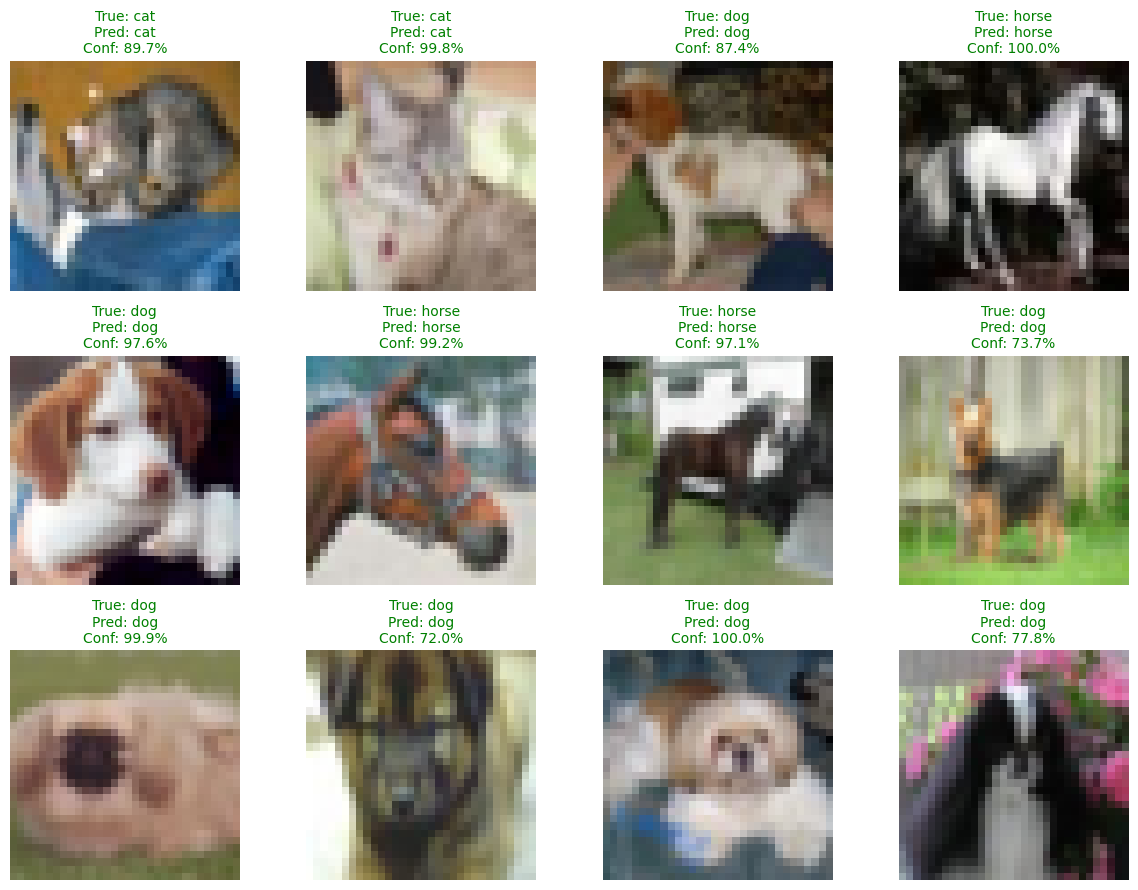

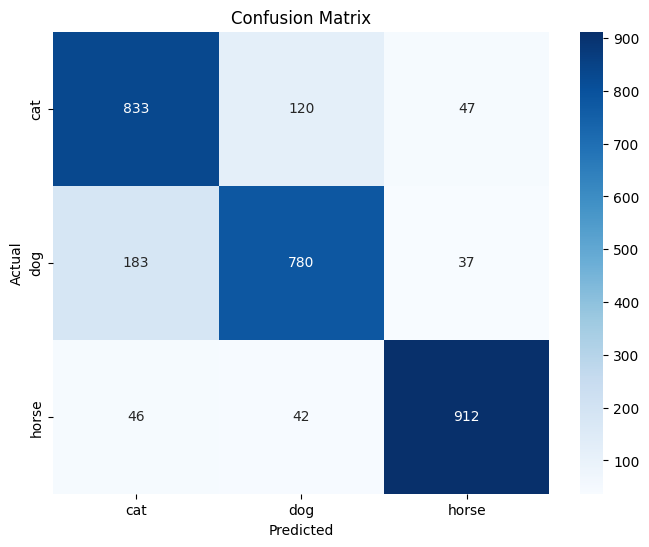


분류 보고서:
              precision    recall  f1-score   support

         cat       0.78      0.83      0.81      1000
         dog       0.83      0.78      0.80      1000
       horse       0.92      0.91      0.91      1000

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



In [5]:
# 예측 테스트 및 시각화
def show_predictions(model, test_loader, num_samples=12):
    model.eval()
    
    # 테스트 데이터에서 샘플 가져오기
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    # 라벨 재매핑
    labels = remap_labels(labels, selected_idx).to(device)
    
    # 예측
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    
    # 시각화
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    axes = axes.ravel()
    
    for i in range(min(num_samples, len(images))):
        # 이미지 역정규화 (시각화용)
        img = images[i].cpu()
        img = img * 0.5 + 0.5  # [-1, 1] -> [0, 1]
        img = torch.clamp(img, 0, 1)
        
        # 이미지 표시
        axes[i].imshow(img.permute(1, 2, 0))
        
        # 예측 결과
        true_label = selected_classes[labels[i].item()]
        pred_label = selected_classes[predicted[i].item()]
        confidence = probabilities[i][predicted[i]].item() * 100
        
        # 색상 설정 (정답이면 초록, 오답이면 빨강)
        color = 'green' if labels[i] == predicted[i] else 'red'
        
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%', 
                         color=color, fontsize=10)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# 예측 결과 시각화
print("예측 결과 시각화:")
show_predictions(model, test_loader)

# 혼동 행렬 (Confusion Matrix)
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = remap_labels(labels, selected_idx).to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # 혼동 행렬 계산
    cm = confusion_matrix(all_labels, all_preds)
    
    # 시각화
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=selected_classes, yticklabels=selected_classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # 분류 보고서
    print("\n분류 보고서:")
    print(classification_report(all_labels, all_preds, target_names=selected_classes))

plot_confusion_matrix(model, test_loader)
